# Deep Neural networks/Multi-layer perceptrons for Sedimentation rate[cm/yr] predictions 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from os import walk
import pickle
from pathlib import Path
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

/gxfs_home/cau/sunms498/miniconda3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def find_nearest(value,vector):
    vector = np.float64(vector)-np.float64(value);
    return np.argmin(np.abs(vector))


,Latitude,Longitude,Sedimentation rate [cm/ka]
count,2782.000000,2782.000000,2782.000000
mean,35.049198,-1.334697,239.359548
std,32.949451,64.898774,432.437500
min,-68.133000,-179.650000,0.000000
25%,26.258250,-18.572475,3.010000
50%,43.150000,9.794000,50.000000
75%,58.752833,23.260125,310.000000
max,82.400000,179.733000,4800.000000


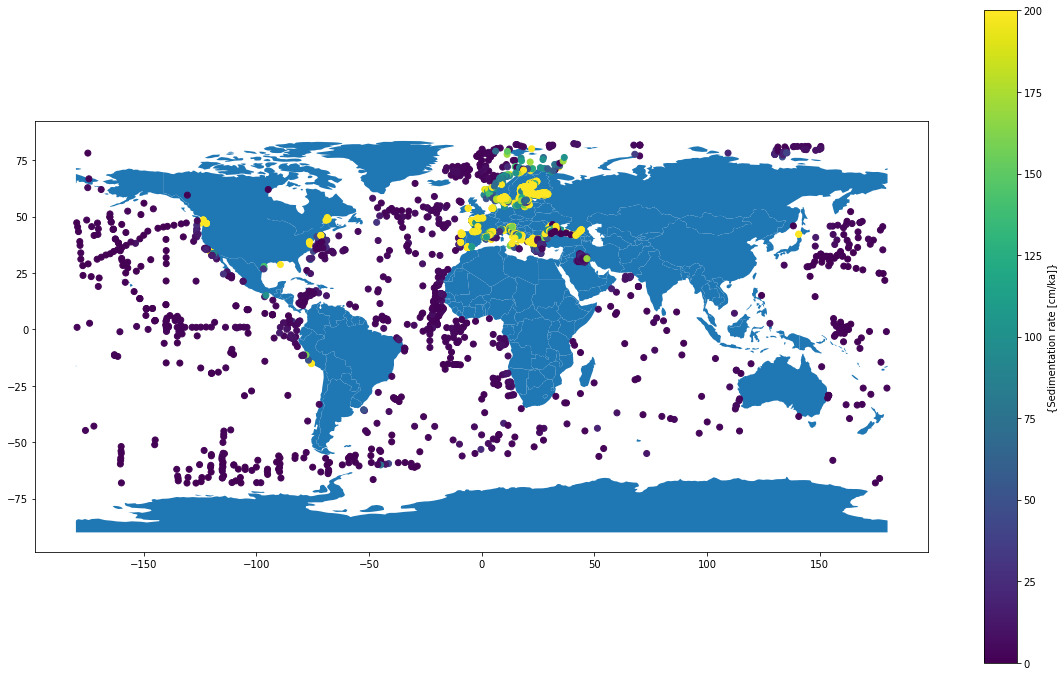

In [3]:
data_path = Path("/gxfs_work1/cau/sunms498/Data/RestrepoKNNsSed") 
sed_labels_file = "sediments_all_updated.xlsx"

df = pd.read_excel(Path(data_path / sed_labels_file))

df = df[["Latitude","Longitude","Sedimentation rate [cm/ka]"]]
df = df[df["Longitude"]>-180]
df = df.dropna(how="any")
df = df[df["Sedimentation rate [cm/ka]"]<5000]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)  
gdf.plot(ax = world.plot(figsize = (20, 12)), column = df["Sedimentation rate [cm/ka]"], vmin = 0, vmax = 200,legend = True, legend_kwds={"label":"{Sedimentation rate [cm/ka]}"});

df.describe()

In this pipe, we read the features at each location(or the nearest location: *find_nearest*) and then store them as a file in a numpy array for each of the measurement location. The length of the numpy array depends on the limit of the sedimentation rate taken. Higher the number, more the number of measurements taken and hence bigger is the numpy array. 

Also here either *Data/Features_Phrampus* or *Data/Features_Phrampus_noNAN* can be used. *Data/Features_Phrampus* includes features that are not interpolated and hence some features contain Nan values which needs to be filtered out during training. Whereas *Data/Features_Phrampus_noNAN* contains interpolated features and hence none of the features contains nan values and hence does not need to be filtered during training. THe difference in the performance between these two needs to be found. Hence the pipeline here can be divided into two.

In [4]:
# feature_image_path ="../../../Data/LeeKNNsTOC/RestrepoFeatureMaps/"
restrepo_features_path = Path("/gxfs_work1/cau/sunms498/Data/Features_Phrampus")
#restrepo_features_path_flipped = Path("/media/sunms498/EXTERNAL_USB/Features_Phrampus_flipped")
restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_features_path):
    restrepo_files.extend(filenames)

restrepo_files.sort()
len(restrepo_files)

print(filenames)

['SF_SEA_CONDUCTIVITY_SM_14SPRING_MEAN_woa13v2x.r500km.aad.5m.grd', 'SS_BIOMASS_BACTERIA_LOG10_MGCM2_WEI2010x.r250km.mlg.5m.grd', 'SF_CURRENT_MAG_MS_2012_12_HYCOMx.r50km.aad.5m.grd', 'GL_RIVERMOUTH_POC_TGCYR-1_ORNL.r1000km.alg.5m.grd', 'SF_SEA_PHOSPHATE_MCML_13WINTER_MEAN_woa13v2x.r125km.aad.5m.grd', 'SF_SEA_PHOSPHATE_MCML_14SPRING_MEAN_woa13v2x.r50km.alg.5m.grd', 'SC_CRUST_THICK_M_CRUST1s.r250km.aad.5m.grd', 'SF_SEA_SEA_OXYGEN_UTILIZATION_MOLM3_DECADAL_MEAN_woa13v2x.r500km.aad.5m.grd', 'CM_MANTLE_VS_MS_CRUST1s.r1000km.alg.5m.grd', 'SF_SEA_TEMPERATURE_C_16FALL_MEAN_woa13v2x.r1000km.aad.5m.grd', 'SF_AVG_SEA_DENSITY_KGM3_DECADAL_MEAN_woa13x.r125km.mlg.5m.grd', 'CM_MANTLE_VP_MS_CRUST1s.r500km.aad.5m.grd', 'SF_SEA_PHOSPHATE_MCML_15SUMMER_MEAN_woa13v2x.r125km.alg.5m.grd', 'SF_SEA_NITRATE_MCML_13WINTER_MEAN_woa13v2x.r250km.aad.5m.grd', 'SF_SEA_PHOSPHATE_MCML_DECADAL_MEAN_woa13v2x.r1000km.aad.5m.grd', 'GL_RIVERMOUTH_TSS_TGYR-1_ORNL.r125km.alg.5m.grd', 'SF_SEA_PHOSPHATE_MCML_16FALL_MEAN_woa13v

In [5]:
rootgrp = xr.open_dataset(Path(restrepo_features_path / restrepo_files[0]), format = 'netcdf4')
latitudes = rootgrp.variables['lat']
longitudes = rootgrp.variables['lon']

restrepo_features = np.empty([len(df),len(restrepo_files[0:len(restrepo_files)])])
restrepo_features[:] = np.nan
restrepo_X_mean = np.empty(0)
restrepo_X_std = np.empty(0)

file_idx = -1
corrupted_files = 0

for file in restrepo_files[0:len(restrepo_files)]:
    file_idx += 1
    try: 
        rootgrp = xr.open_dataset(Path(restrepo_features_path / file), format = 'NETCDF4')
    except:
        restrepo_X_mean = np.append(restrepo_X_mean,np.nan)
        restrepo_X_std = np.append(restrepo_X_std,np.nan)
        corrupted_files = corrupted_files + 1
        continue

    
#     latitudes = rootgrp.variables['lats'] # in theory all the same
#     longitudes = rootgrp.variables['lons']
    
    # dataset = rootgrp.variables['z']
    # if Features_Phrampus_noNAN is used just use rootgrp.variables['data']
    if file_idx == 182:
        dataset = rootgrp.variables['data']
    else:
        dataset = rootgrp.variables['z']
    restrepo_X_mean = np.append(restrepo_X_mean,np.nanmean(dataset))
    restrepo_X_std = np.append(restrepo_X_std,np.nanstd(dataset))
    # if file == "GL_LAND_IS_1.0_ETOPO2v2.5m.nc":
    #     dataset = rootgrp.variables['data']
    # else:
    #dataset = rootgrp.variables['data']

    for data_idx in range(0,len(df)):
        lat_idx = find_nearest(df.iloc[data_idx,0], latitudes)
        lon_idx = find_nearest(df.iloc[data_idx,1], longitudes)
        restrepo_features[data_idx, file_idx] = dataset[lat_idx, lon_idx]
        # latitudes_labels.append(latitudes[lat_idx])
        # longitudes_labels.append(longitudes[lon_idx])
    
    print("file " + str(file_idx) + " done!")
    
print("corrupted files: " + str(corrupted_files))
# chlor_features_path = Path(data_path / "FeaturesEwa")
# chlor_files = []

# for (dirpath, dirnames, filenames) in walk(chlor_features_path):
#     chlor_files.extend(filenames)

# chlor_files.sort()
# len(chlor_files)
# print(chlor_files)

/gxfs_home/cau/sunms498/miniconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


file 0 done!
file 1 done!
file 2 done!
file 3 done!
file 4 done!
file 5 done!
file 6 done!
file 7 done!
file 8 done!
file 9 done!
file 10 done!
file 11 done!
file 12 done!
file 13 done!
file 14 done!
file 15 done!
file 16 done!
file 17 done!
file 18 done!
file 19 done!
file 20 done!
file 21 done!
file 22 done!
file 23 done!
file 24 done!



KeyboardInterrupt



In [ ]:
print("corrupted files: " + str(corrupted_files))

features = np.concatenate([restrepo_features], axis = 1)
X_mean = np.concatenate([restrepo_X_mean])
X_std = np.concatenate([restrepo_X_std])
features.shape


save_path = Path(Path() / "SedFeatures_nolimit")
np.save(Path(save_path / "numpy_features"), features)
np.save(Path(save_path / "numpy_labebels"), df["Sedimentation rate [cm/ka]"].values)
np.save(Path(save_path / "numpy_log+1_labebels"), np.log10(df["Sedimentation rate [cm/ka]"].values+1))
# np.save(Path(save_path / "numpy_latitudes_labels"), latitudes_labels)
# np.save(Path(save_path / "numpy_longitudes_labels"), longitudes_labels)
np.save(Path(save_path / "features_mean"),X_mean)
np.save(Path(save_path / "features_std"),X_std)

files = []
for file in restrepo_files:
    files.append(file)

# for file in chlor_files:
#     files.append(file)
    
with open(Path(save_path / "sorted_features.txt"), "wb") as fp:   #Pickling
    pickle.dump(files, fp)


### *!!PARALLEL PIPELINE HERE FOR INCLUDING INTERPOLATED FEATURES!!*
Need not run if non-interpolated features needs to be used. Find out the interpolated files!

In [ ]:
# feature_image_path ="../../../Data/LeeKNNsTOC/RestrepoFeatureMaps/"
restrepo_features_path = Path("/gxfs_work1/cau/sunms498/Data/Features_Phrampus_noNaN")
#restrepo_features_path_flipped = Path("/media/sunms498/EXTERNAL_USB/Features_Phrampus_flipped")
restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_features_path):
    restrepo_files.extend(filenames)

restrepo_files.sort()
len(restrepo_files)

rootgrp = xr.open_dataset(Path(restrepo_features_path / restrepo_files[0]), format = 'netcdf4')
latitudes = rootgrp.variables['lat']
longitudes = rootgrp.variables['lon']

restrepo_features = np.empty([len(df),len(restrepo_files[0:len(restrepo_files)])])
restrepo_features[:] = np.nan
restrepo_X_mean = np.empty(0)
restrepo_X_std = np.empty(0)

file_idx = -1
corrupted_files = 0

for file in restrepo_files[0:len(restrepo_files)]:
    file_idx += 1
    try: 
        rootgrp = xr.open_dataset(Path(restrepo_features_path / file), format = 'NETCDF4')
    except:
        restrepo_X_mean = np.append(restrepo_X_mean,np.nan)
        restrepo_X_std = np.append(restrepo_X_std,np.nan)
        corrupted_files = corrupted_files + 1
        continue

    
#     latitudes = rootgrp.variables['lats'] # in theory all the same
#     longitudes = rootgrp.variables['lons']
    
    # dataset = rootgrp.variables['z']
    # if Features_Phrampus_noNAN is used just use rootgrp.variables['data']
    dataset = rootgrp.variables['data']
    restrepo_X_mean = np.append(restrepo_X_mean,np.nanmean(dataset))
    restrepo_X_std = np.append(restrepo_X_std,np.nanstd(dataset))
    # if file == "GL_LAND_IS_1.0_ETOPO2v2.5m.nc":
    #     dataset = rootgrp.variables['data']
    # else:
    #dataset = rootgrp.variables['data']

    for data_idx in range(0,len(df)):
        lat_idx = find_nearest(df.iloc[data_idx,0], latitudes)
        lon_idx = find_nearest(df.iloc[data_idx,1], longitudes)
        restrepo_features[data_idx, file_idx] = dataset[lat_idx, lon_idx]
        # latitudes_labels.append(latitudes[lat_idx])
        # longitudes_labels.append(longitudes[lon_idx])
    
    print("file " + str(file_idx) + " done!")
    
print("corrupted files: " + str(corrupted_files))
# chlor_features_path = Path(data_path / "FeaturesEwa")
# chlor_files = []

# for (dirpath, dirnames, filenames) in walk(chlor_features_path):
#     chlor_files.extend(filenames)

# chlor_files.sort()
# len(chlor_files)
# print(chlor_files)

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from os import walk
from pathlib import Path
import gc
from skimage.transform import resize
from time import sleep
from multiprocessing import pool


In [104]:
restrepo_input_path = Path("../../../Data/Features_Phrampus_noNaN/") 

restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_input_path):
    restrepo_files.extend(filenames)
    break

restrepo_files.sort()
print(len(restrepo_files))

datasets = []
ii = 0
corrupted_files = 0

# land_file = Path(lee_input_path / "GL_LAND_IS_1.0_ETOPO2v2.5m.nc")
# rootgrp = xr.open_dataset(land_file)
# dataset = rootgrp['data']
# plt.imshow(dataset)

# np.save(Path(lee_input_path.parent / "is_land_map"), np.asarray(dataset).astype(np.bool))

1845


In [112]:
 #for idx in range(0, len(files)):
for file in restrepo_files[0:len(restrepo_files)]:   
    
    try: 

        rootgrp = xr.open_dataset(Path(restrepo_input_path / file), format = 'NETCDF4')
    except:
        datasets.append(np.nan)
        corrupted_files = corrupted_files + 1
        continue
    # if file == "POROSITY_global_prediction.grd":
    #     dataset = rootgrp.variables['z']
    # dataset = rootgrp.variables['data'] if Features_Phrampus_noNan is used
    if ii==182:
        dataset = rootgrp.variables['data']
        
    else:
        dataset = rootgrp.variables['data']
    
    #plt.imshow(dataset)
    #dataset = rootgrp.variables['z']
    datasets.append(dataset)
    ii+=1
    print("File " + str(ii) + " of " + str(len(restrepo_files)))
    
print(str(corrupted_files) + " corrupted files")

File 1846 of 1845
File 1847 of 1845
File 1848 of 1845
File 1849 of 1845
File 1850 of 1845
File 1851 of 1845
File 1852 of 1845
File 1853 of 1845
File 1854 of 1845
File 1855 of 1845
File 1856 of 1845
File 1857 of 1845
File 1858 of 1845
File 1859 of 1845
File 1860 of 1845
File 1861 of 1845
File 1862 of 1845
File 1863 of 1845
File 1864 of 1845
File 1865 of 1845
File 1866 of 1845
File 1867 of 1845
File 1868 of 1845
File 1869 of 1845
File 1870 of 1845
File 1871 of 1845
File 1872 of 1845
File 1873 of 1845
File 1874 of 1845
File 1875 of 1845
File 1876 of 1845
File 1877 of 1845
File 1878 of 1845
File 1879 of 1845
File 1880 of 1845
File 1881 of 1845
File 1882 of 1845
File 1883 of 1845
File 1884 of 1845
File 1885 of 1845
File 1886 of 1845
File 1887 of 1845
File 1888 of 1845
File 1889 of 1845
File 1890 of 1845
File 1891 of 1845
File 1892 of 1845
File 1893 of 1845
File 1894 of 1845
File 1895 of 1845
File 1896 of 1845
File 1897 of 1845
File 1898 of 1845
File 1899 of 1845
File 1900 of 1845
File 1901 

In [113]:
# chlor_features_path = Path(Path().resolve().parents[2] / "Data" / "LeeKNNsTOC" / "FeaturesEwa") 
# chlor_files = []

# for (dirpath, dirnames, filenames) in walk(chlor_features_path):
#     chlor_files.extend(filenames)

# chlor_files.sort()
# print(len(chlor_files))


#output_path = Path(Path().resolve().parents[2] / "Data" / "RestrepoKNNsSed" / "WorldFeaturesAll")#ChlorWorldFeatures
output_path = Path("../../../Data/RestrepoKNNsSed/WorldFeaturesAllPCAnoNan")


num_proc=16

chunks = 360 # dataset.shape[0]/chunks must be int
chunks_mp=360/num_proc
lat_step = np.int(dataset.shape[0]/chunks)

   
# for idx in range(0, len(datasets)):
#     feature_chunk = np.zeros([int(dataset.shape[0]/chunks * dataset.shape[1]), len(datasets)] )  
#     if datasets[idx] is not np.nan:
#         feature_chunk[:,idx] = np.asarray(datasets[idx][ii*lat_step:ii*lat_step + lat_step,:]).flatten(order = "C")
#     else:
#         feature_chunk[:,idx] = np.nan
                         

# np.save(Path(output_path / save_name) , feature_chunk)    
# print("Chunk " + str(ii+1) + " of " + str(chunks) + " written!")

/scratch/SlurmTMP/sunms498.5974599/ipykernel_1505782/1919046715.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat_step = np.int(dataset.shape[0]/chunks)


In [118]:
from sklearn.decomposition import PCA

for ii in range(0,chunks):

    feature_chunk = np.zeros([int(dataset.shape[0]/chunks * dataset.shape[1]), len(datasets)] )
        
    for idx in range(0, len(datasets)):
        
        if datasets[idx] is not np.nan:
            feature_chunk[:,idx] = np.asarray(datasets[idx][ii*lat_step:ii*lat_step + lat_step,:]).flatten(order = "C")
            # the code below choose minimum number of principal components such that 95 % of the variance is retained.
            # pca = PCA(0.95) 
            # pca.fit(feature_chunk)
            # feature_chunk=pca.transform(feature_chunk)
        else:
            feature_chunk[:,idx] = np.nan
                         
    save_name = "Sed_world_feature_" + str(ii).zfill(3)
    np.save(Path(output_path / save_name) , feature_chunk)    
    print("Chunk " + str(ii+1) + " of " + str(chunks) + " written!")


Chunk 1 of 360 written!


KeyboardInterrupt: 

In [119]:
print(feature_chunk.shape)
pca = PCA(0.95) 
pca.fit(feature_chunk)
feature_chunk=pca.transform(feature_chunk)
print(feature_chunk.shape)

(25920, 5535)
(25920, 3)


In [ ]:
print(str(corrupted_files) + " corrupted files")

plt.imshow(feature_chunk)


0 corrupted files


### Features that contain NaN values and hence removed

In [ ]:
# feature_image_path ="../../../Data/LeeKNNsTOC/RestrepoFeatureMaps/"
restrepo_features_path = Path("/gxfs_work1/cau/sunms498/Data/Features_Phrampus")
#restrepo_features_path_flipped = Path("/media/sunms498/EXTERNAL_USB/Features_Phrampus_flipped")
restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_features_path):
    restrepo_files.extend(filenames)

restrepo_files.sort()
len(restrepo_files)

print(filenames[nan_rows])


## Train Neural Network

The jupyter notebook shows predictions from a neural network(tensorflow) and a linear regression model(sci-kit). 

Note: the jupyter notebook is not runnable from here. Requires the data. Here is j

### Multi-layer Perceptron

In [1]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from os import path, makedirs
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

#tf.config.experimental.set_memory_growth(physical_devices[0], True) # solves some GPU memory issues 
np.random.seed(42)
tf.random.set_seed(42)

#print(physical_devices)

2022-10-19 15:49:03.040937: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


**Load data** and pre-processing.

THe feature data has been interpolated using nearest neighbour algorithm to interpolate nan values. In total, we have around 1850 features. 

### **To note: Some features are also averaged over r1000km, r500km, r250km, r100km and r50km. If these are excluded, then the number of features drop down to less than 200.**

But here we also take the averaged feature, since it helps acquiring the neighbourhood data, which the predictions or the sedimentation rates might depend on. 

Since the **dimensions are too high**, and probably the neural network might find it difficult to learn, we try to use some **dimensionality reduction methods, such as PCA, and using a auto encoder**. 

The code for **auto encoder** is at the end of the jupyter notebook

In [2]:
feature_path = Path(Path() / "SedFeaturesnoNAN_nolimit")
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labebels.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)
#lat_labels = np.load(Path(feature_path / "numpy_latitudes_labels.npy")).astype(np.float)
#lon_labels = np.load(Path(feature_path / "numpy_longitudes_labels.npy")).astype(np.float)


#Norm Features
features = np.divide((features - X_mean),X_std)

with open(Path(feature_path / "sorted_features.txt"), "rb") as fp:
    feature_names = pickle.load(fp)


prediction_limit = 5000

# features = features[:,selection_filter]
features = features[labels<prediction_limit,:] #take only TOC < 5% 
# lat_labels = lat_labels[labels<prediction_limit]
# lon_labels = lon_labels[labels<prediction_limit]
labels = labels[labels<prediction_limit]
# labels[labels>prediction_limit] = prediction_limit

#Drop features with NaNs
nan_rows = np.isnan(features).any(axis=0)
np.save("FeatureNanRows",nan_rows)
features = features[:,~nan_rows]
print(nan_rows)



# suffle features/labels
shuffle_idx = np.random.mtrand.randint(low = 0, high = len(labels), size = len(labels))
features = features[shuffle_idx,:]
labels = labels[shuffle_idx]

#features = encoded_features.numpy()
print(features.shape)



#taking the log of labels so that the order of maginitude between deep oceans and the coasts is reduced
#loglabels=np.log10(labels)

model = [None]*10
MAE = []
corrcoef = []
kf = KFold(n_splits=10)
mc_samples = 50


[False False False ... False False False]
(2782, 1845)
(2782, 301)


In [ ]:

# #PCA
pca = PCA (0.995) #95% of the variance is retained
pca.fit(features)
features = pca.transform(features)
print(features.shape)

In [3]:
#features = encoded_features.numpy()
#early stopping and LR-scheduling callbacks
#checkpoint_cb = keras.callbacks.ModelCheckpoint('TOC_nn.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "loss", patience = 200, restore_best_weights = True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.8, patience = 40, min_lr = 0.000001)
do_rate = 0.2
num_nodes = 50
    
model_seed = keras.models.Sequential()
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))




model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))





model_seed.add(keras.layers.Dense(1, activation = "relu"))

model_seed.build([None,features.shape[1]])


2022-10-19 15:49:06.345492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 15:49:06.345662: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:

#%%timeit -n 1 -r 1
#fold = 0
#for train, test in kf.split(features, labels): #startification/10fold
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=1)    
#print("computing fold " + str(fold+1))




model = keras.models.clone_model(model_seed)
model.set_weights(model_seed.get_weights())
model.compile(loss = "mean_absolute_error",
             optimizer = keras.optimizers.Nadam(learning_rate = 0.01),
             metrics = [["RootMeanSquaredError"]])
 
#Final run with early stopping callback
print("running main training round")
 
 
history = model.fit(features_train, labels_train,  epochs = 10000, batch_size= 70, 
                      callbacks = [ early_stopping_cb,lr_scheduler],verbose =2,validation_split=0.2)#
 

running main training round
Epoch 1/10000


2022-10-19 15:49:06.703437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-19 15:49:06.717225: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


26/26 - 6s - loss: 204.1874 - root_mean_squared_error: 459.6160 - val_loss: 965.7999 - val_root_mean_squared_error: 1883.0189
Epoch 2/10000
26/26 - 0s - loss: 147.2378 - root_mean_squared_error: 374.2854 - val_loss: 1315.4680 - val_root_mean_squared_error: 2682.9966
Epoch 3/10000
26/26 - 0s - loss: 129.4066 - root_mean_squared_error: 345.8346 - val_loss: 911.9351 - val_root_mean_squared_error: 2099.5518
Epoch 4/10000
26/26 - 0s - loss: 125.4910 - root_mean_squared_error: 341.5972 - val_loss: 386.9729 - val_root_mean_squared_error: 800.3328
Epoch 5/10000
26/26 - 0s - loss: 118.2907 - root_mean_squared_error: 330.1470 - val_loss: 340.5625 - val_root_mean_squared_error: 715.8318
Epoch 6/10000
26/26 - 0s - loss: 115.7598 - root_mean_squared_error: 325.2259 - val_loss: 208.4768 - val_root_mean_squared_error: 476.6469
Epoch 7/10000
26/26 - 0s - loss: 114.2101 - root_mean_squared_error: 327.8219 - val_loss: 249.0681 - val_root_mean_squared_error: 529.3050
Epoch 8/10000
26/26 - 0s - loss: 109.

In [5]:
#MC Dropout
probs_stack = np.stack([model(features_test,training = True) for sample in range(mc_samples)]) 
probs_stack = probs_stack.reshape([probs_stack.shape[0],probs_stack.shape[1]])
np.savetxt("probs_stack_regression.txt", probs_stack.T)
np.savetxt("labels_test_regression.txt", labels_test)
predictions = tf.squeeze(probs_stack.mean(axis = 0))
np.savetxt("predictions_regression.txt", predictions)
corrcoef.append(np.corrcoef(predictions, labels_test)[0,1])
MAE.append(mean_absolute_error(labels_test,predictions))
 
history_df = pd.DataFrame(history.history)#
#print(history_df)
#print("best val accuracy: " + str(np.max(history_df.val_accuracy)))
print("test MAE:" + str(MAE))
print("test correlation coeficient:" + str(corrcoef))
print("     ----     ")
#fold = fold+1

test MAE:[92.40137333960874]
test correlation coeficient:[0.7396501054759339]
     ----     


In [68]:
features.shape

(2782, 75)

Correlation Coefficient: 0.5435806858197414
MAE: 119.61127704994004
0.6203907501130623
(2782,)
(557,)


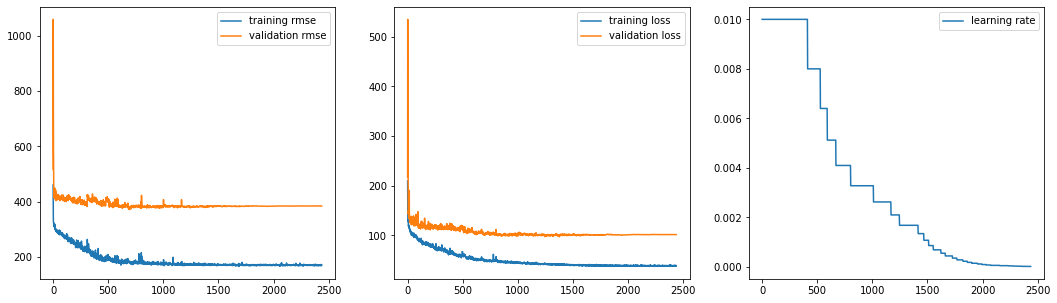

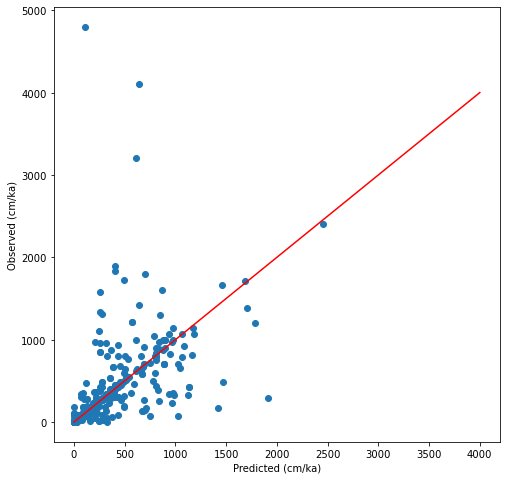

In [69]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(history_df.root_mean_squared_error)
plt.plot(history_df.val_root_mean_squared_error)
plt.legend(["training rmse", "validation rmse"])
#plt.ylim([100,4000])
plt.subplot(132)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(["training loss", "validation loss"])
#plt.ylim([20,400])
plt.subplot(133)
plt.plot(history_df.lr)
plt.legend(["learning rate"])

print("Correlation Coefficient: "+str(np.sum(corrcoef)/len(corrcoef)))
print("MAE: " +str(np.sum(MAE)/len(MAE)))


plt.figure(figsize=[8,8])
#plt.clf()
plt.scatter(predictions,labels_test)
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
plt.xlabel("Predicted (cm/ka)")
plt.ylabel("Observed (cm/ka)")
print(np.corrcoef(predictions,labels_test)[0,1])

dirname = Path("Sed_regresion_083_RestrepoFeats_AllVS0.2_Test")
if not path.isdir(dirname):
    makedirs(dirname)
 
# for idx, model in enumerate(model):
model_name = "Model_nolimitnonan_Test"  + ".h5"
model.save(Path(dirname / model_name))
    
print(labels.shape)
print(labels_test.shape)




## Regression

In [70]:
#%%timeit -n 1 -r 1
#fold = 0
#for train, test in kf.split(features, labels): #startification/10fold
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=1)    
#print("computing fold " + str(fold+1))

In [71]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(features_train, labels_train)
features.shape

(2782, 75)

(557,)
(557, 75)
0.5416621066634344


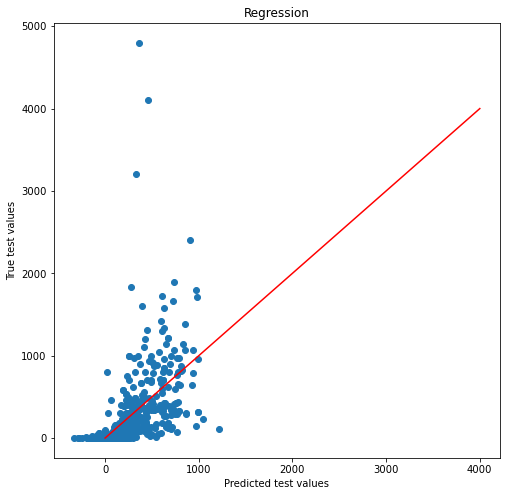

In [72]:
print(reg.predict(features_test).shape)
print(features_test.shape)
plt.figure(figsize=[8,8])
plt.scatter(reg.predict(features_test), labels_test)
plt.title("Regression")
plt.xlabel("Predicted test values")
plt.ylabel("True test values")
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
print(np.corrcoef(reg.predict(features_test), labels_test)[0,1])

## Auto encoder

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

In [7]:
features.shape

(2782, 1845)

In [60]:
# This is the dimension of the original space
input_dim = features.shape[1]

# This is the dimension of the latent space (encoding space)
latent_dim = 75

encoder = Sequential([
    Dense(1000, activation='relu', input_shape=(input_dim,)),
    Dense(500, activation='relu'),
    Dense(250, activation='relu'),
    Dense(100, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(100, activation='relu', input_shape=(latent_dim,)),
    Dense(250, activation='relu'),
    Dense(500, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(input_dim, activation=None)
])

In [61]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

Epoch 1/1000
40/40 - 1s - loss: 3.0299
Epoch 2/1000
40/40 - 0s - loss: 1.4897
Epoch 3/1000
40/40 - 0s - loss: 1.0581
Epoch 4/1000
40/40 - 0s - loss: 0.8350
Epoch 5/1000
40/40 - 0s - loss: 0.6975
Epoch 6/1000
40/40 - 0s - loss: 0.6065
Epoch 7/1000
40/40 - 0s - loss: 0.5717
Epoch 8/1000
40/40 - 0s - loss: 0.5323
Epoch 9/1000
40/40 - 0s - loss: 0.4578
Epoch 10/1000
40/40 - 0s - loss: 0.4381
Epoch 11/1000
40/40 - 0s - loss: 0.4101
Epoch 12/1000
40/40 - 0s - loss: 0.3605
Epoch 13/1000
40/40 - 0s - loss: 0.3720
Epoch 14/1000
40/40 - 0s - loss: 0.3587
Epoch 15/1000
40/40 - 0s - loss: 0.3616
Epoch 16/1000
40/40 - 0s - loss: 0.3366
Epoch 17/1000
40/40 - 0s - loss: 0.3110
Epoch 18/1000
40/40 - 0s - loss: 0.2979
Epoch 19/1000
40/40 - 0s - loss: 0.2794
Epoch 20/1000
40/40 - 0s - loss: 0.2343
Epoch 21/1000
40/40 - 0s - loss: 0.2142
Epoch 22/1000
40/40 - 0s - loss: 0.2210
Epoch 23/1000
40/40 - 0s - loss: 0.2773
Epoch 24/1000
40/40 - 0s - loss: 0.2374
Epoch 25/1000
40/40 - 0s - loss: 0.2433
Epoch 26/

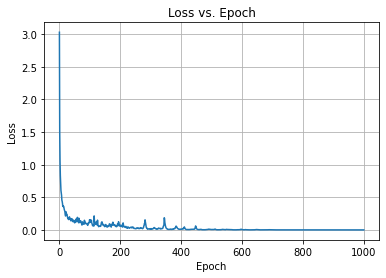

In [62]:
model_history = autoencoder.fit(features, features, epochs=1000, batch_size=70, callbacks = [ early_stopping_cb,lr_scheduler],verbose =2)

plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

Text(0, 0.5, 'Latent Dimension 2')

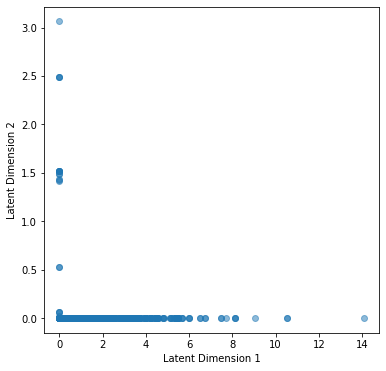

In [64]:
encoded_features = encoder(features)
plt.figure(figsize=(6,6))
plt.scatter(encoded_features[:, 44], encoded_features[:, 9], alpha=.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

In [23]:
np.linalg.norm(features - autoencoder(features).numpy())

66.98173444749557